In [98]:
from traffic.core.types import altitude
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import gudhi

from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_persistence, sublevelset_persistence, sublevelset_heading_persistence
from functions.data_loading import flights_from_query

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from traffic.core import Traffic, Flight
from gudhi.representations import Landscape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
flights, data = flights_from_query(None, "./data/GA_dataset.pkl", load_results=True)

In [100]:
filtered_flight_data = [(f, d) for f, d in zip(flights, data) if large_gap_filter(f)]
flights, data = zip(*filtered_flight_data)  
flights = list(flights)
data = np.array(data)
simple = True

labels = data[:, 0]
if simple: 
    labels = (labels != 1).astype(int)

outside_data = data[:, 1:]

In [47]:
persistence, paths = flight_persistence(flights)
altitude_sub_persistence, altitude_sub_paths = sublevelset_persistence(flights, "geoaltitude")
speed_sub_persistence, speed_sub_paths = sublevelset_persistence(flights, "groundspeed")
heading_sub_persistence, heading_sub_paths = sublevelset_heading_persistence(flights)

100%|██████████| 7910/7910 [00:32<00:00, 241.46it/s]


In [101]:
def persistence_stats(persistences):
    dataset = []
    for pers in persistences:
        births = pers[:, 0]
        deaths = pers[:, 1]
        lifespans = deaths - births
        
        data_row = [len(pers)]

        for i in [lifespans]:
            #get top 5 and pad with 0s if there are less than 5 items
            i.sort()
            data = i[:5]   
            data = np.pad(data, (0, max(0, 5 - len(data))), mode='constant')
            
            mean = np.mean(i) if len(i) != 0 else 0
            median = np.median(i) if len(i) != 0 else 0
            
            data = list(data)  # Convert back to a list
            data.extend([mean, median])
            
            data_row.extend(data)  # Collect into row
        dataset.append(data_row)  
    dataset = np.array(dataset)
    return dataset

In [102]:
pers_stats = persistence_stats(persistence)
altitude_sub_pers_stats = persistence_stats(altitude_sub_persistence)
speed_sub_pers_stats = persistence_stats(speed_sub_persistence)
heading_sub_pers_stats = persistence_stats(heading_sub_persistence)

In [103]:
from tqdm import tqdm
baseline = []

for flight in tqdm(flights, total=len(flights)):
    data = flight.data.copy(deep=True)
    
    unwrapped = np.unwrap(np.deg2rad(data["track"]), period=2 * np.pi, discont=np.pi)
    max_unwrapped = unwrapped.max()
    min_unwrapped = unwrapped.min()
    diff_unwrapped = max_unwrapped - min_unwrapped
    
    max_velocity = data["groundspeed"].max()
    min_velocity = data["groundspeed"].min()
    mean_velocity = data["groundspeed"].mean()
    max_heading = data["vertical_rate"].max()
    min_heading = data["vertical_rate"].min()
    mean_heading = data["vertical_rate"].mean()
    longitude_diff = data["longitude"].max() - data["longitude"].min()
    latitude_diff = data["latitude"].max() - data["latitude"].min()
    
    baseline.append([max_unwrapped, min_unwrapped, diff_unwrapped, max_velocity, min_velocity, mean_velocity, max_heading, min_heading, mean_heading, longitude_diff, latitude_diff])

100%|██████████| 7910/7910 [00:06<00:00, 1302.75it/s]


In [104]:
baseline = np.array(baseline)

In [233]:
resolution = 10
n_landscapes = 3
landscape = Landscape(resolution=resolution, num_landscapes=n_landscapes)

landscapes = [landscape.fit_transform([pers]) for pers in persistence]
altitude_sub_landscapes = [landscape.fit_transform([pers]) for pers in altitude_sub_persistence]
speed_sub_landscapes = [landscape.fit_transform([pers]) for pers in speed_sub_persistence]
heading_sub_landscapes = [landscape.fit_transform([pers]) for pers in heading_sub_persistence]
    
landscapes = np.array(landscapes)
landscapes = landscapes.reshape(landscapes.shape[0], landscapes.shape[2])
altitude_sub_landscapes = np.array(altitude_sub_landscapes)
altitude_sub_landscapes = altitude_sub_landscapes.reshape(altitude_sub_landscapes.shape[0], altitude_sub_landscapes.shape[2])
speed_sub_landscapes = np.array(speed_sub_landscapes)
speed_sub_landscapes = speed_sub_landscapes.reshape(speed_sub_landscapes.shape[0], speed_sub_landscapes.shape[2])
heading_sub_landscapes = np.array(heading_sub_landscapes)
heading_sub_landscapes = heading_sub_landscapes.reshape(heading_sub_landscapes.shape[0], heading_sub_landscapes.shape[2])

In [245]:
heading_sub_landscapes.shape

(7910, 30)

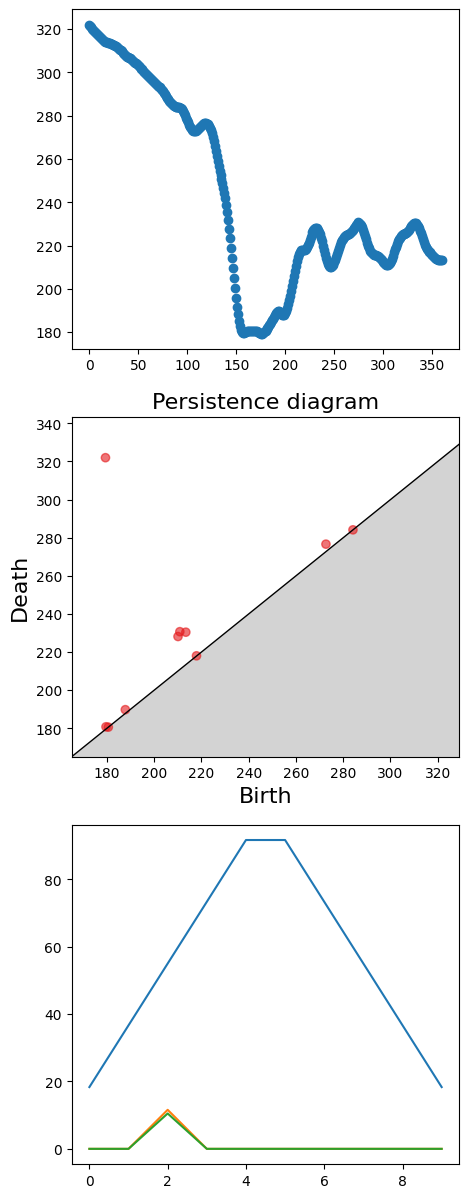

In [106]:
diagram = 3001
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

diagrams = []
diagrams.append([
    paths[diagram],
    persistence[diagram],
    landscapes[diagram]
])
diagrams.append([
    altitude_sub_paths[diagram],
    altitude_sub_persistence[diagram],
    altitude_sub_landscapes[diagram]
])
diagrams.append([
    speed_sub_paths[diagram],
    speed_sub_persistence[diagram],
    speed_sub_landscapes[diagram]
])
diagrams.append([
    heading_sub_paths[diagram],
    heading_sub_persistence[diagram],
    heading_sub_landscapes[diagram]
])

i = 2

path = diagrams[i][0]
pers = diagrams[i][1]
landscape = diagrams[i][2]

axs[0].scatter(path[:, 0], path[:, 1])
gudhi.persistence_graphical_tools.plot_persistence_diagram(pers, axes=axs[1])

for i in range(n_landscapes):
    axs[2].plot(landscape[i*resolution:(i+1)*resolution])

In [217]:
 from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn import svm

seed = 42

regressors = {
    "Support Vector Machines" : [svm.SVR(), {
        "C" : [0.1, 1, 10], 
        "kernel": ["rbf", "poly"],
        "degree": [2, 3, 4],
    }],
    "Base line" : [DummyRegressor(strategy = "mean"), {
        
    }],
    "Multi-layer Perception" : [MLPRegressor(random_state=seed, max_iter = 5000), {
        "hidden_layer_sizes" : [10, 20, 30], 
        
    }],
    "K Nearest Neighbors" : [KNeighborsRegressor(), {
        "n_neighbors" : [5, 10, 20, 40], 
        "p": [1, 2, 3]
    }],
    "Random Forrest Regressor" : [RandomForestRegressor(random_state=seed), {
        "max_depth": [3, 6], 
        "n_estimators" : [25, 50, 100]
    }],
    "Decision Tree Regressor" : [DecisionTreeRegressor(random_state=seed), {
        "min_samples_split" : [2, 3, 4],
        "min_samples_leaf" : [1, 2, 3]
    }],
}

classifiers = {
    "Support Vector Machines": [svm.SVC(random_state=seed), {
        "C" : [0.1, 1, 10], 
        "kernel": ["rbf", "poly"],
        "degree": [2, 3, 4],
    }],
    "Base line": [DummyClassifier(strategy="most_frequent"), {

    }],
    "Multi-layer Perception": [MLPClassifier(random_state=seed, max_iter=5000), {
        "hidden_layer_sizes": [10, 20, 30],

    }],
    "K Nearest Neighbors": [KNeighborsClassifier(), {
        "n_neighbors": [5, 10, 20, 40],
        "p": [1, 2, 3]
    }],
    "Random Forrest Regressor": [RandomForestClassifier(random_state=seed), {
        "max_depth": [3, 6],
        "n_estimators": [50, 100, 300]
    }],
    "Decision Tree Regressor": [DecisionTreeClassifier(random_state=seed), {
        "min_samples_split": [2, 3, 4],
        "min_samples_leaf": [1, 2, 3]
    }],
}

In [228]:
B = [baseline, outside_data]
LL = [pers_stats]
A = [altitude_sub_pers_stats]
S = [speed_sub_pers_stats]
H = [heading_sub_pers_stats]
LL_A_H = LL + A + H
B_LL_A_H = B + LL_A_H

X = np.concatenate(B+LL+H, axis= 1)

mask = ~np.any(np.isnan(X), axis=1)
X = X[mask]
Y = labels[mask]

indices = np.arange(len(X))

x_train, x_test_val, y_train, y_test_val, indices_train, indices_test_val = train_test_split(X, Y, indices, test_size=0.3, random_state=seed)

#normalizer = preprocessing.Normalizer()
#x_train = normalizer.fit_transform(x_train)
#x_test_val = normalizer.transform(x_test_val)

x_test, x_val, y_test, y_val, indices_test, indices_val = train_test_split(x_test_val, y_test_val, indices_test_val, test_size=0.5, random_state=seed)

In [229]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV

datalist = []
models = classifiers if simple else regressors

for i in models.keys():
    #does the gridsearch on the models
    model = GridSearchCV(models[i][0], models[i][1])
    #makes a prediction
    prediction = model.fit(x_train, y_train).predict(x_test)
    if simple:
        error =  balanced_accuracy_score(y_test, np.round(prediction))
    else:
        error = root_mean_squared_error(y_test, prediction)
    
    datalist.append([model.best_estimator_, error])

In [230]:
for i, j in datalist:
    print(f"{i.__repr__(): <70}: {j: .3}")

SVC(C=10, degree=2, random_state=42)                                  :  0.984
DummyClassifier(strategy='most_frequent')                             :  0.5
MLPClassifier(hidden_layer_sizes=30, max_iter=5000, random_state=42)  :  0.977
KNeighborsClassifier()                                                :  0.981
RandomForestClassifier(max_depth=6, n_estimators=300, random_state=42):  0.993
DecisionTreeClassifier(min_samples_leaf=2, random_state=42)           :  0.989


In [231]:
new_x_train =  np.concatenate((x_train, x_test), axis=0)
new_y_train = np.concatenate((y_train, y_test), axis=0)

if simple:
    best_model = sorted(datalist, key=lambda x: x[1], reverse=True)[0][0]
    prediction = best_model.fit(new_x_train, new_y_train).predict(x_val)
    error =  balanced_accuracy_score(y_val, np.floor(prediction))
else:
    best_model = sorted(datalist, key=lambda x: x[1], reverse=False)[0][0]
    prediction = best_model.fit(new_x_train, new_y_train).predict(x_val)
    error = root_mean_squared_error(y_val, prediction)

error

0.9948528313819182

In [232]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, np.round(prediction))

array([[626,   3],
       [  3, 540]], dtype=int64)

#### B:          0.992
#### S:          0.948
#### H:          0.982
#### A:          0.949
#### LL:         0.943
#### S+H+A:      0.980
#### LL+S+H+A:   0.984
#### B+LL+S+H+A: 0.994
#### B+H:        0.995
#### B+LL+H      0.995
#### B+LL+S+H    0.996

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.

### adding sublevel set height:
this doesnt seem to improve the results, and mostly just confuses the models :/


NameError: name 'sub_paths' is not defined

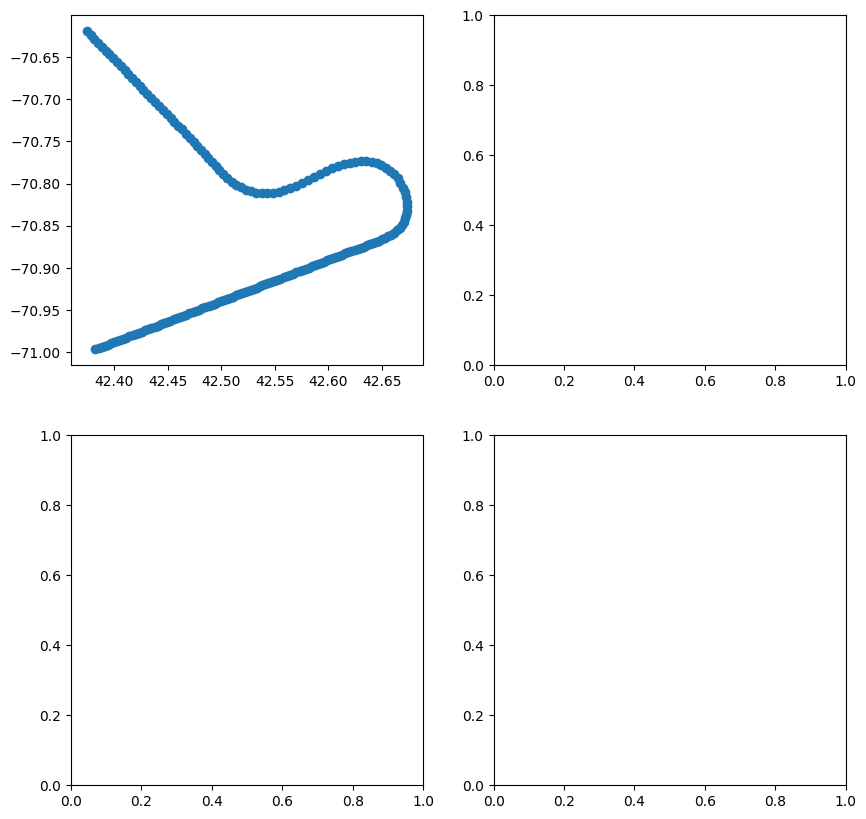

In [113]:
false_negatives = np.where(np.logical_and(y_val == 1, prediction == 0))[0]
false_positives = np.where(np.logical_and(y_val == 0, prediction == 1))[0]
positives = np.where(y_val == 1)[0]


index = 0
index = indices_val[false_positives[index]]
#index = indices_val[false_negatives[index]]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
path = paths[index]
axs[0, 0].scatter(path[:, 0], path[:, 1])

path = altitude_sub_paths[index]
axs[0, 1].scatter(path[:, 0], path[:, 1])

gudhi.persistence_graphical_tools.plot_persistence_diagram(sub_persistence[index], axes=axs[1, 1])
gudhi.persistence_graphical_tools.plot_persistence_diagram(persistence[index], axes=axs[1, 0])

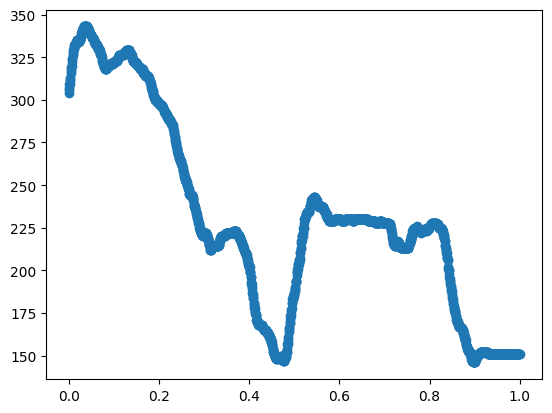

In [30]:
index = 2000
path = flights[index].data["groundspeed"]
#path = np.unwrap(np.deg2rad(data["velocity"]), period=2 * np.pi, discont=np.pi)

x_values = [x / len(path) for x in range(len(path))]
plt.scatter(x_values, path)

In [26]:
flights[index].data["groundspeed"]

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,onground,alert,spi,squawk,altitude,geoaltitude,last_position,serials,hour
712,2019-01-05 00:41:52+00:00,7c6de4,-37.400440,145.734061,327.0,236.844030,-1920.0,QFA853,False,False,False,4361,19050.0,19700.0,1546648911.679,"[-1408236462, -1408237257]",2019-01-05 00:00:00+00:00
713,2019-01-05 00:41:53+00:00,7c6de4,-37.401352,145.732299,327.0,236.844030,-1920.0,QFA853,False,False,False,4361,19025.0,19700.0,1546648912.892,"[-1408236462, -1408237257]",2019-01-05 00:00:00+00:00
714,2019-01-05 00:41:54+00:00,7c6de4,-37.402070,145.730836,327.0,236.844030,-1920.0,QFA853,False,False,False,4361,19000.0,19650.0,1546648913.707,"[-1408236462, -1408237257]",2019-01-05 00:00:00+00:00
715,2019-01-05 00:41:55+00:00,7c6de4,-37.402908,145.729284,327.0,236.990835,-1792.0,QFA853,False,False,False,4361,18975.0,19600.0,1546648914.711,"[-1408236462, -1408237257]",2019-01-05 00:00:00+00:00
716,2019-01-05 00:41:56+00:00,7c6de4,-37.403824,145.727507,327.0,236.990835,-1792.0,QFA853,False,False,False,4361,18950.0,19575.0,1546648915.766,"[-1408236462, -1408237257]",2019-01-05 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2019-01-05 01:11:48+00:00,7c6de4,-37.535302,144.812941,178.0,171.278302,-832.0,QFA853,False,False,False,4361,2775.0,2825.0,1546650707.448,"[-1408237515, -1408236462]",2019-01-05 01:00:00+00:00
708,2019-01-05 01:11:49+00:00,7c6de4,-37.535628,144.813000,178.0,171.278302,-832.0,QFA853,False,False,False,4361,2775.0,2825.0,1546650708.132,"[-1408237515, -1408236462]",2019-01-05 01:00:00+00:00
709,2019-01-05 01:11:50+00:00,7c6de4,-37.536850,144.813245,177.0,171.229237,-896.0,QFA853,False,False,False,4361,2750.0,2800.0,1546650709.65,"[-1408237515, -1408236462]",2019-01-05 01:00:00+00:00
710,2019-01-05 01:11:51+00:00,7c6de4,-37.536850,144.813245,177.0,171.229237,-896.0,QFA853,False,False,False,4361,2725.0,2800.0,1546650709.65,"[-1408237515, -1408236462]",2019-01-05 01:00:00+00:00


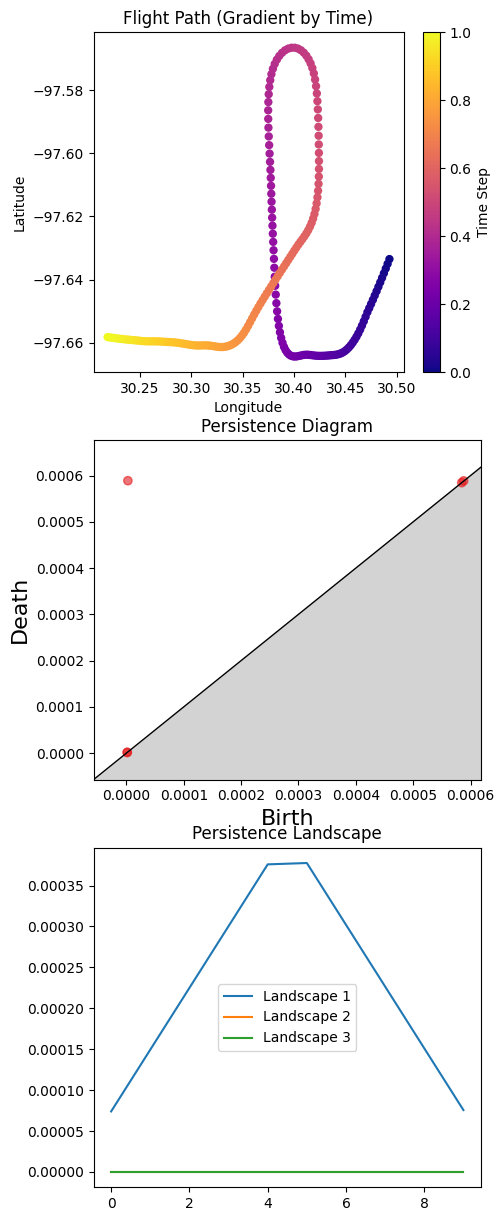

array([[ 31.06104249, -97.26519158],
       [ 31.05297229, -97.26833922],
       [ 31.04497529, -97.27145647],
       [ 31.03705149, -97.27454333],
       [ 31.02920088, -97.2775998 ],
       [ 31.02142347, -97.28062587],
       [ 31.01371925, -97.28362155],
       [ 31.00608824, -97.28658684],
       [ 30.99853041, -97.28952174],
       [ 30.99104579, -97.29242624],
       [ 30.98363436, -97.29530036],
       [ 30.97629613, -97.29814408],
       [ 30.96903109, -97.30095741],
       [ 30.9616887 , -97.30378771],
       [ 30.95459763, -97.30651791],
       [ 30.94759785, -97.30921208],
       [ 30.94067702, -97.31187438],
       [ 30.93383986, -97.31450844],
       [ 30.92705352, -97.31712514],
       [ 30.92033424, -97.31972059],
       [ 30.91367916, -97.3222964 ],
       [ 30.90705173, -97.32487245],
       [ 30.90044791, -97.32744591],
       [ 30.89390953, -97.33000022],
       [ 30.88737866, -97.33254187],
       [ 30.88087765, -97.33504455],
       [ 30.8743728 , -97.33753666],
 

In [258]:
from functions.objects import PersistenceData
pers, data = persistence[:10], paths[:10]
p = PersistenceData(pers, data)
p.plot_diagram(9)
paths[0]

In [243]:
paths[:10][0]

array([[ 31.06104249, -97.26519158],
       [ 31.05297229, -97.26833922],
       [ 31.04497529, -97.27145647],
       [ 31.03705149, -97.27454333],
       [ 31.02920088, -97.2775998 ],
       [ 31.02142347, -97.28062587],
       [ 31.01371925, -97.28362155],
       [ 31.00608824, -97.28658684],
       [ 30.99853041, -97.28952174],
       [ 30.99104579, -97.29242624],
       [ 30.98363436, -97.29530036],
       [ 30.97629613, -97.29814408],
       [ 30.96903109, -97.30095741],
       [ 30.9616887 , -97.30378771],
       [ 30.95459763, -97.30651791],
       [ 30.94759785, -97.30921208],
       [ 30.94067702, -97.31187438],
       [ 30.93383986, -97.31450844],
       [ 30.92705352, -97.31712514],
       [ 30.92033424, -97.31972059],
       [ 30.91367916, -97.3222964 ],
       [ 30.90705173, -97.32487245],
       [ 30.90044791, -97.32744591],
       [ 30.89390953, -97.33000022],
       [ 30.88737866, -97.33254187],
       [ 30.88087765, -97.33504455],
       [ 30.8743728 , -97.33753666],
 